# PD3
Indywidualnie, nauczyć i wyjaśnić wybrany model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji w torch na wybranym zbiorze danych zawierającym: ponad 5000 zdjęć o rozmiarze ponad 128x128 przynależących do ponad 5 klas. Powstały raport w formatach .ipynb oraz .html powinien zawierać wnioski z przeprowadzonej analizy.

- do 2 punktów uzyskuje się za wytrenowanie skutecznego i nieprzeuczonego modelu CNN (pokazać uczenie na zbiorze treningowym i testowym),
- do 2 punktów uzyskuje się za wizualizację 6+ wybranych zdjęć, a dla każdego z nich po 3+ wybranych wyjaśnień (algorytmów jest wiele, ale może być też analiza parametrów danej metody),
- do 2 punktów uzyskuje się za analizę wyjaśnień błędnie zaklasyfikowanych zdjęć,
- do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu),
- do 2 punktów można uzyskać za dodatkowe ciekawe wyniki i eksperymenty związane z wyjaśnianiem CNN i klasyfikacji zdjęć.

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

Deadline: 13 kwietnia 23:59. Na zajęciach 14 kwietnia wybrane osoby krótko zaprezentuje swoje wyniki.

Pracę zgłaszamy poprzez PR o tytule [PD3] Imię Nazwisko do folderu homeworks/pd3/imię_nazwisko.



## 1. Wczytanie danych

In [14]:
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu"

In [26]:
torch.cuda.is_available()


True

In [4]:
!pip install kaggle
!mkdir ~/.kaggle
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Mounted at /content/drive
100% 3.24G/3.24G [03:03<00:00, 94.0MB/s]
100% 3.24G/3.24G [03:03<00:00, 19.0MB/s]


In [1]:
!pip install cython


In [2]:
import torch
import torchvision
import torchinfo
import torchvision.transforms as transforms
import captum
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)


In [1]:
#!unzip '/content/a-large-scale-fish-dataset.zip'

In [ ]:
from pathlib import Path
import os
# Data path
data_dir = Path(r'../content/Fish_Dataset/Fish_Dataset')

# Filter fanction for remove 'GT' images
filter_GT = lambda x : True if os.path.split(os.path.split(x)[0])[1][-2:] != 'GT' else False
map_label = lambda x : os.path.split(os.path.split(x)[0])[1]

# Get image paths and labels
img_dir = list(filter(filter_GT, data_dir.glob(r'**/*.png')))
label = list(map(map_label, img_dir))

# Create the paths data
data = pd.DataFrame({'img_dir':img_dir, 'label':label}).astype('str')
types = data['label'].unique()
n_types = len(types)

print(types)
print(n_types)

['Gilt-Head Bream' 'Red Sea Bream' 'Black Sea Sprat' 'Hourse Mackerel'
 'Sea Bass' 'Red Mullet' 'Striped Red Mullet' 'Shrimp' 'Trout']
9


In [ ]:
data.head()

,img_dir,label
0,../content/Fish_Dataset/Fish_Dataset/Gilt-Head...,Gilt-Head Bream
1,../content/Fish_Dataset/Fish_Dataset/Gilt-Head...,Gilt-Head Bream
2,../content/Fish_Dataset/Fish_Dataset/Gilt-Head...,Gilt-Head Bream
3,../content/Fish_Dataset/Fish_Dataset/Gilt-Head...,Gilt-Head Bream
4,../content/Fish_Dataset/Fish_Dataset/Gilt-Head...,Gilt-Head Bream


In [ ]:
for Type in types:
    n = data.loc[data['label']==Type, 'label'].count()
    print(f'{n} ===> {Type}')

1000 ===> Gilt-Head Bream
1000 ===> Red Sea Bream
1000 ===> Black Sea Sprat
1000 ===> Hourse Mackerel
1000 ===> Sea Bass
1000 ===> Red Mullet
1000 ===> Striped Red Mullet
1000 ===> Shrimp
1000 ===> Trout


In [ ]:
# Count image sizes
image_sizes = data['img_dir'].apply(lambda x : plt.imread(x).shape)
print(image_sizes.value_counts())

(445, 590, 3)    9000
Name: img_dir, dtype: int64


In [ ]:
data = data.sample(frac=1).reset_index(drop = True)

In [25]:
transform = transforms.Compose([
            transforms.Resize([128,128]), # Resizing the image as the VGG only take 224 x 244 as input size
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
data = torchvision.datasets.ImageFolder('../content/Fish/', transform=transform)

In [26]:
data

Dataset ImageFolder
    Number of datapoints: 9000
    Root location: ../content/Fish/
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [27]:
data_train, _ = torch.utils.data.random_split(data, [5150, 3850])
data_test, data_train = torch.utils.data.random_split(data_train, [150, 5000])
data_loader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=32, shuffle=True)
data_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=32, shuffle=True)


## 2. Budowa modelu CCN

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.dropout = nn.Dropout(dropout)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.dropout(out)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=9, dropout=0.0, name='ResNet'):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2, dropout=dropout)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, dropout=dropout)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, dropout=dropout)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2, dropout=dropout)
        self.linear = nn.Linear(1024*block.expansion, num_classes)
        
        self.dropout = nn.Dropout(dropout)
        
        self.name = name
        
    def _make_layer(self, block, planes, num_blocks, stride, dropout):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def __name__(self):
        return self.name
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], dropout=0.15, name = 'ResNet18')


In [10]:

# put all hyper params into a OrderedDict, easily expandable
from collections  import OrderedDict
params = OrderedDict(
    model = [ResNet18],
    lr = [.001],
    batch_size = [32]
)
epochs = 8
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
    def __init__(self):

        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        # record model, loader and TensorBoard 
        self.network = None
        self.loader = None
        self.loader_test = None
        self.tb = None

    # record the count, hyper-param, model, loader of each run
    # record sample images and network graph to TensorBoard  
    def begin_run(self, run, network, loader, loader_test):

        self.run_start_time = time.time()

        self.run_params = run
        self.run_count += 1

        self.network = network
        self.loader = loader
        self.loader_test = loader_test
        
        self.tb = SummaryWriter(comment=f'-Run({run[0].__name__}, lr={run[1]}, batch_size={run[2]})')

        images, labels = next(iter(self.loader))
        
        grid = torchvision.utils.make_grid(images.to(DEVICE))

        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images.to(DEVICE))
        
        images_test, labels_test = next(iter(self.loader_test))
        
        grid = torchvision.utils.make_grid(images_test.to(DEVICE))

        self.tb.add_image('images test', grid)
        self.tb.add_graph(self.network, images_test.to(DEVICE))
        

    # when run ends, close TensorBoard, zero epoch count
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0

    # zero epoch count, loss, accuracy, 
    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
        self.epoch_loss_train = 0
        self.epoch_num_correct_train = 0
        
        self.epoch_loss_test = 0
        self.epoch_num_correct_test = 0

    # 
    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        # record epoch loss and accuracy
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        loss_train = self.epoch_loss_train / len(self.loader.dataset)
        accuracy_train = self.epoch_num_correct_train / len(self.loader.dataset)
        
        loss_test = self.epoch_loss_test / len(self.loader_test.dataset)
        accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)
        
        # Record epoch loss and accuracy to TensorBoard 
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        self.tb.add_scalar('Loss train', loss_train, self.epoch_count)
        self.tb.add_scalar('Accuracy train', accuracy_train, self.epoch_count)
        
        self.tb.add_scalar('Loss test', loss_test, self.epoch_count)
        self.tb.add_scalar('Accuracy test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)

        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        results["run"] = self.run_count
        results["model"] = network.__name__
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        
        results["loss_train"] = loss_train
        results["accuracy_train"] = accuracy_train
        
        results["loss_test"] = loss_test
        results["accuracy_test"] = accuracy_test
        
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        

        # Record hyper-params into 'results'
        for k,v in self.run_params._asdict().items(): results[k] = v.__name__ if k == 'model' else v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

        # display epoch information and show progress
        clear_output(wait=True)
        display(df)

    # accumulate loss of batch into entire epoch loss
    def track_loss(self, loss):
        # multiply batch size so variety of batch sizes can be compared
        self.epoch_loss += loss.item() * self.loader.batch_size
    
    def track_loss_train(self, loss):
        # multiply batch size so variety of batch sizes can be compared
        self.epoch_loss_train += loss.item() * self.loader.batch_size
    
    def track_loss_test(self, loss):
        # multiply batch size so variety of batch sizes can be compared
        self.epoch_loss_test += loss.item() * self.loader_test.batch_size
    
    
    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
    def track_num_correct_train(self, preds, labels):
        self.epoch_num_correct_train += self._get_num_correct(preds, labels)
        
    def track_num_correct_test(self, preds, labels):
        self.epoch_num_correct_test += self._get_num_correct(preds, labels)

    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    # save end results of all runs into csv, json for further analysis
    def save(self, fileName):

        pd.DataFrame.from_dict(
            self.run_data, 
            orient = 'columns',
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [27]:

m = RunManager()
networks = OrderedDict()
optimizers = OrderedDict()
    # get all runs from params using RunBuilder class
for run in RunBuilder.get_runs(params):

        # if params changes, following line of code should reflect the changes too
        network = run.model().to(DEVICE)
        loader = data_loader
        loader_test = data_loader_test 
        optimizer = optim.Adam(network.parameters(), lr=run.lr)

        m.begin_run(run, network, loader, loader_test)
        for epoch in range(epochs):

            m.begin_epoch()
            
            for batch in loader:
                
                images = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds = network(images)
                loss = F.cross_entropy(preds, labels)
                
                m.track_loss_train(loss)
                m.track_num_correct_train(preds, labels)
            
            for batch in loader_test:
                
                images = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds = network(images)
                loss = F.cross_entropy(preds, labels)
                
                m.track_loss_test(loss)
                m.track_num_correct_test(preds, labels)
            
            for batch in loader:

                images = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)
                preds = network(images)
                loss = F.cross_entropy(preds, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                m.track_loss(loss)
                m.track_num_correct(preds, labels)
                
            m.end_epoch()
        m.end_run()
        networks[m.run_count] = network
        optimizers[m.run_count] = optimizer
    # when all runs are done, save results to files
m.save('final_results')
def save_networks(networks, optimizers, path='network.pth'):
    networks_state = OrderedDict()
    optimizers_state = OrderedDict()
    
    for run in networks:
        networks_state[run] = networks[run].state_dict()
        optimizers_state[run] = optimizers[run].state_dict()
        
    torch.save({
        'networks': networks_state,
        'optimizers': optimizers_state
    }, path)



save_networks(networks, optimizers, 'network.pth')
#!cp -av './network.pth' '/content/gdrive/My Drive/results/'
    

,run,model,epoch,loss,accuracy,loss_train,accuracy_train,loss_test,accuracy_test,epoch duration,run duration,lr,batch_size
0,1,ResNet18,1,1.076848,0.5934,2.387502,0.1096,2.502259,0.100000,172.864432,185.250269,0.001,32
1,1,ResNet18,2,0.510591,0.8198,0.851630,0.6988,0.827983,0.713333,171.386220,357.979092,0.001,32
2,1,ResNet18,3,0.357860,0.8784,0.306865,0.8962,0.348091,0.886667,175.369524,534.594872,0.001,32
3,1,ResNet18,4,0.207339,0.9244,0.256501,0.9088,0.217255,0.920000,172.086653,707.953308,0.001,32
4,1,ResNet18,5,0.158547,0.9460,0.142503,0.9492,0.145990,0.933333,171.857964,881.093938,0.001,32
5,1,ResNet18,6,0.203020,0.9276,0.130678,0.9538,0.331255,0.920000,171.636930,1053.954482,0.001,32
6,1,ResNet18,7,0.149982,0.9496,0.134649,0.9552,0.165814,0.966667,171.816478,1227.065369,0.001,32
7,1,ResNet18,8,0.144829,0.9504,0.119605,0.9578,0.161481,0.960000,171.107308,1399.373889,0.001,32


Zastosowany ResNet18 z dropoutem 0.15, dał zadawalające accuracy na zbiorze testowym równe 0.96. Będziemy go używać do analizy wyjaśnień.

## 3. Wczytanie modelu

In [5]:
!cp -r /content/drive/MyDrive/Fish /content/Fish


In [6]:
!cp /content/drive/MyDrive/network.pth /content/network.pth


In [20]:
def load_networks(path):
    checkpoint = torch.load(path,map_location=torch.device('cpu'))
    models = [ResNet18]
    
    networks = OrderedDict()
    optimizers = OrderedDict()
    for run in range(1,2):
        networks[run] = models[run-1]()
        optimizers[run] = optim.Adam(networks[run].parameters(), lr=0.001)
        
        networks[run].load_state_dict(checkpoint['networks'][run])
        networks[run].to(DEVICE)
        optimizers[run].load_state_dict(checkpoint['optimizers'][run])
    
    return networks, optimizers

In [21]:
networks, optimizers = load_networks('network.pth')

In [22]:
model = networks[1]

## Macierz konfuzji

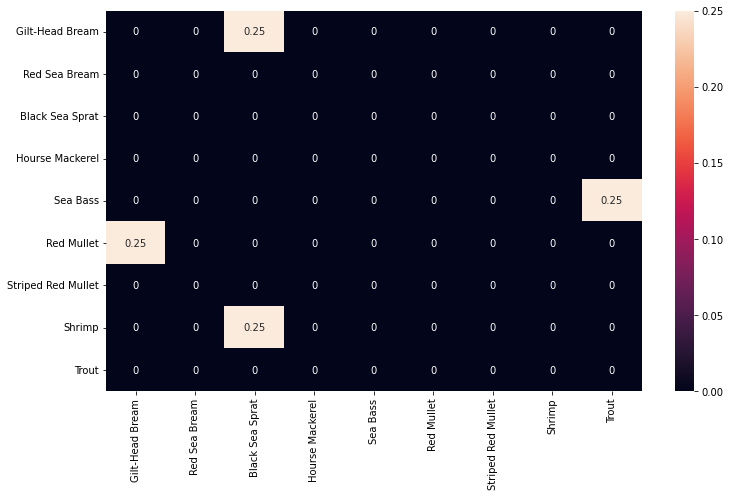

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for X, y in data_loader_test:
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        output = pred.argmax(1).type(torch.float).cpu()
        y_pred.extend(output) # Save Prediction
        labels = y.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Gilt-Head Bream', 'Red Sea Bream' ,'Black Sea Sprat' ,'Hourse Mackerel',
 'Sea Bass' ,'Red Mullet' ,'Striped Red Mullet', 'Shrimp' ,'Trout')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
normalized = cf_matrix - np.diag(np.diag(cf_matrix))
df_cm = pd.DataFrame(normalized / np.sum(normalized), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.show()

## 4. Analiza zdjęć

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


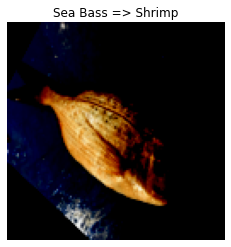

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


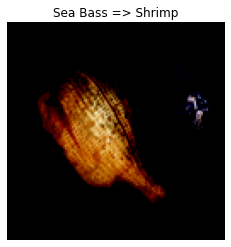

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


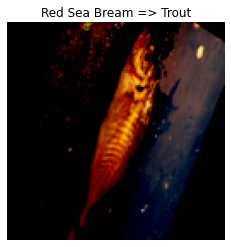

In [51]:
def error_pictures(k,m,title):
  mistakes = []
  p = y_pred

  for i in range(150):
    if data_test[i][1] == k:
      if p[i] == m:
        mistakes += [i]

  for i in range(len(mistakes)):
    images, labels = data_test[mistakes[i]]
    plt.title(title)
    plt.imshow(images.cpu().permute(1, 2, 0))
    plt.axis("off")
    print(labels)
    plt.show()
  
error_pictures(4,7,"Sea Bass => Shrimp")
error_pictures(2,8,"Red Sea Bream => Trout")


In [48]:
preds_correct=0
for i in range(150):
  if y_pred[i] == y_true[i]:
    preds_correct+=1

print('total correct:', preds_correct)
print('accuracy:', preds_correct / 150)

total correct: 146
accuracy: 0.9733333333333334


## 5. Integrated Gradients (IG)

In [70]:
classes = ('Gilt-Head Bream', 'Red Sea Bream' ,'Black Sea Sprat' ,'Hourse Mackerel',
 'Sea Bass' ,'Red Mullet' ,'Striped Red Mullet', 'Shrimp' ,'Trout')
def imgshow(images,labels):
  plt.axis("off")
  plt.imshow(images.cpu().permute(1, 2, 0))
  print(classes[labels])
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trout


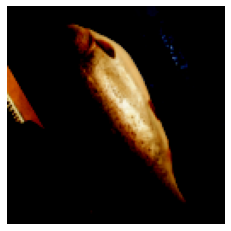

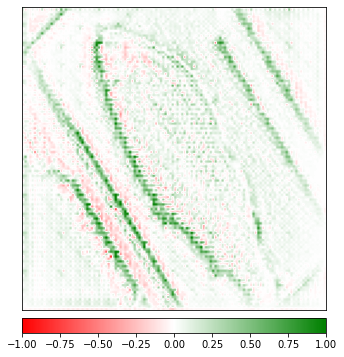

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Black Sea Sprat


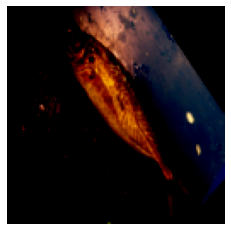

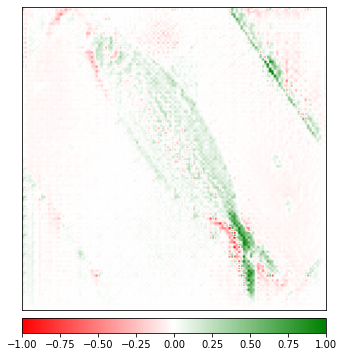

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Striped Red Mullet


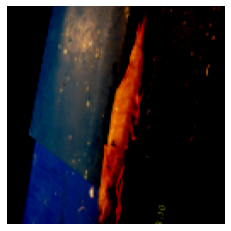

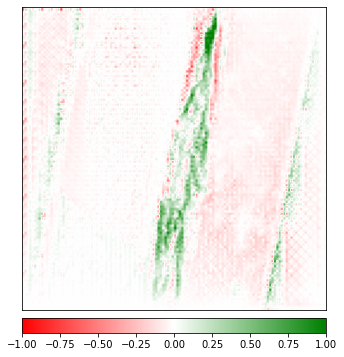

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hourse Mackerel


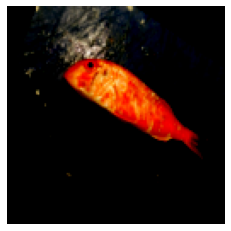

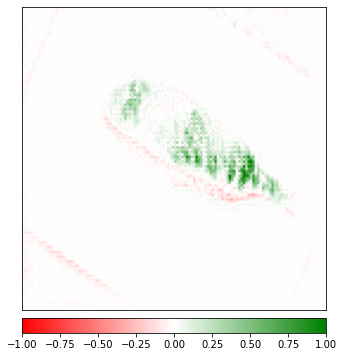

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shrimp


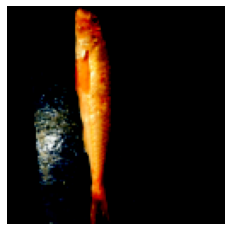

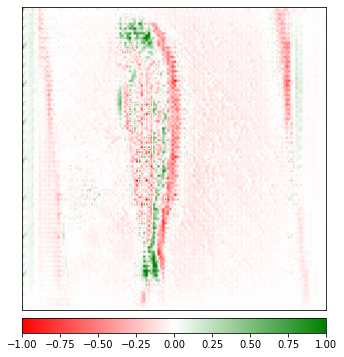

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gilt-Head Bream


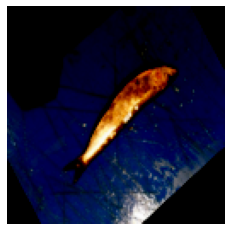

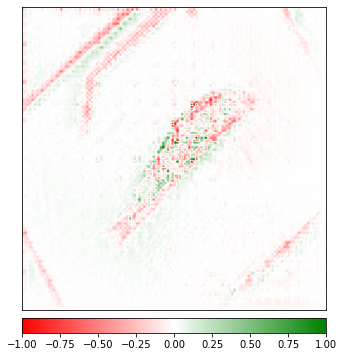

In [72]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
from captum.attr import IntegratedGradients
for i in range(20,26):
  X, label = data_test[i]
  X.cpu().permute(1, 2, 0)
  imgshow(X,label)
  exp_ig = IntegratedGradients(model)
  attr_ig = exp_ig.attribute(X.unsqueeze(0), target=label)
  show_attr(attr_ig[0])


## 6. Shap

Kernel Shap attribution: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trout


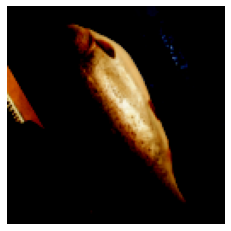

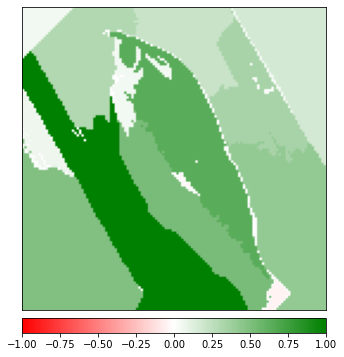

Kernel Shap attribution: 100%|██████████| 200/200 [01:25<00:00,  2.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Black Sea Sprat


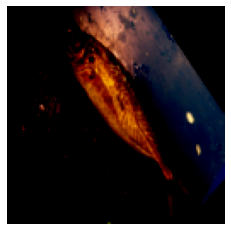

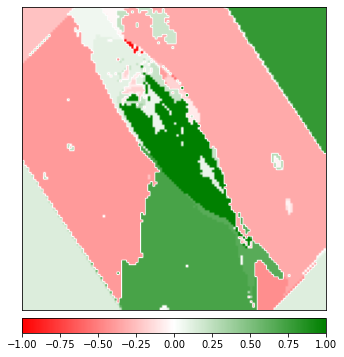

Kernel Shap attribution: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Striped Red Mullet


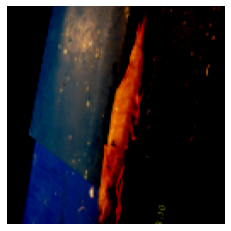

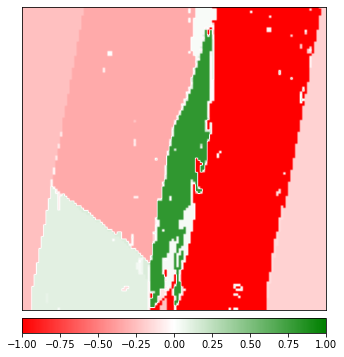

Kernel Shap attribution: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hourse Mackerel


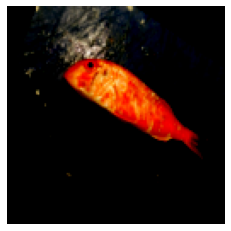

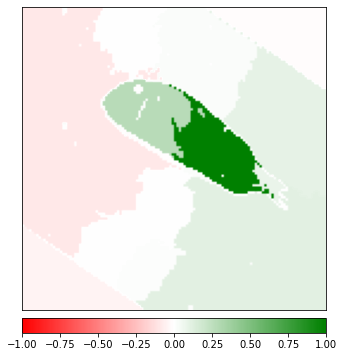

Kernel Shap attribution: 100%|██████████| 200/200 [01:07<00:00,  2.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shrimp


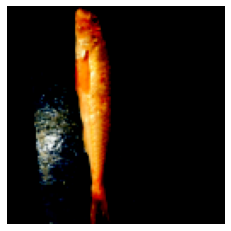

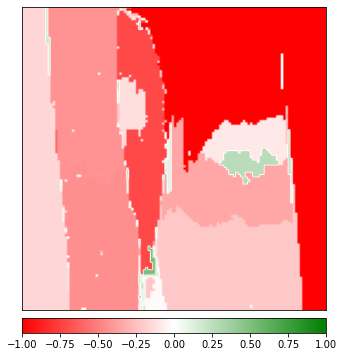

Kernel Shap attribution: 100%|██████████| 200/200 [01:09<00:00,  2.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gilt-Head Bream


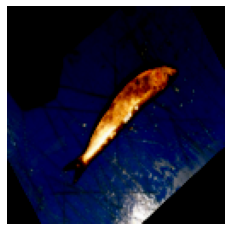

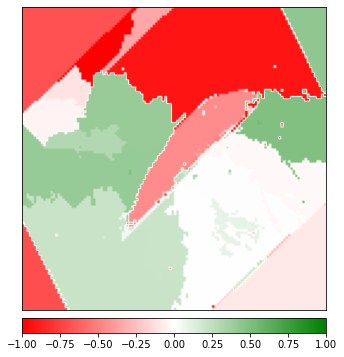

In [84]:
from captum.attr import KernelShap
for i in range(20,26):
  X, label = data_test[i]
  X = X.double()
  mask = segmentation.quickshift(
          X.permute(1, 2, 0), 
          kernel_size=14, 
          max_dist=7, 
          ratio=0.5
        )
  exp_ks = KernelShap(model.double())

  exp_ks = exp_ks.attribute(
          X.unsqueeze(0),
          target=label, 
          n_samples=200, 
          feature_mask=torch.as_tensor(mask),
          show_progress=True
        )
  imgshow(X,label)
  show_attr(exp_ks[0])

## 7. Wnioski

Metoda zintegrowanych gradientów daje ciekawe wnioski. W niektórych przypadkach zaznacza jedynie kontury, lecz udało jej się wyłapać też wzór na rybie, co faktycznie powinno identyfikować jej gatunek. Shap w większości przypadków zaznacza tło, więc jego skuteczność w tłumaczeniu sieci nie jest za duża.